# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.onnx
import onnx
import onnxruntime

from qdrant_client import QdrantClient
from qdrant_client.models import Distance

from luxonis_ml.data.dataset import HType, IType, LDFComponent, LuxonisDataset, BucketStorage

from luxonis_ml.embeddings.data_utils import *
from luxonis_ml.embeddings.model_utils import *
from luxonis_ml.embeddings.embedding_utils import *
from luxonis_ml.embeddings.qdrant_utils import *
from luxonis_ml.embeddings.ldf_emb import *

/home/paperspace/Luxonis/lux-ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch examples

In [2]:
# Load the data
data_loader = load_mnist_data(save_path='./mnist', num_samples=640, batch_size=64)

In [3]:

# Load the model
model = load_model_resnet50_minuslastlayer()

In [4]:

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, data_loader)

In [5]:

save_embeddings(embeddings, labels)

## ONNX models and Qdrant

In [6]:
# Load the data
data_loader = load_mnist_data(save_path='./mnist', num_samples=640, batch_size=64)

In [7]:
# Load the model
model = load_model()

# Export the model to ONNX
export_model_onnx(model, model_path_out="resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(onnx_model, intermediate_tensor_name="/Flatten_output_0")

# Save the ONNX model
onnx.save(onnx_model, "resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = ['CUDAExecutionProvider'] if torch.cuda.is_available() and 'CUDAExecutionProvider' in onnxruntime.get_available_providers() else None
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(ort_session, data_loader)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels)

In [9]:
embeddings, labels = load_embeddings()

In [10]:
# Connect to Qdrant
client = connect_to_qdrant()

# Create a collection
vector_size = embeddings.shape[1]
create_collection(client, collection_name="mnist2", vector_size=vector_size, distance=Distance.COSINE)

# Insert the embeddings into the collection
# insert_embeddings(client, embeddings, labels, collection_name="mnist")
# insert_embeddings_nooverwrite(client, embeddings, labels, collection_name="mnist")
batch_insert_embeddings_nooverwrite(client, embeddings, labels, batch_size=50, collection_name="mnist2")

Collection already exists
No new embeddings to insert for batch 0-50
No new embeddings to insert for batch 50-100
No new embeddings to insert for batch 100-150
No new embeddings to insert for batch 150-200
No new embeddings to insert for batch 200-250
No new embeddings to insert for batch 250-300


No new embeddings to insert for batch 300-350
No new embeddings to insert for batch 350-400
No new embeddings to insert for batch 400-450
No new embeddings to insert for batch 450-500
No new embeddings to insert for batch 500-550
No new embeddings to insert for batch 550-600
No new embeddings to insert for batch 600-640


In [11]:
# Search for the nearest neighbors
search_results = search_embeddings(client, embeddings[0], collection_name="mnist2", top=5)

# Print the search results
print(np.array(search_results))

[ScoredPoint(id=310, version=6, score=1.0000001, payload={'label': 0}, vector=None)
 ScoredPoint(id=264, version=5, score=0.9203315, payload={'label': 0}, vector=None)
 ScoredPoint(id=416, version=8, score=0.9195281, payload={'label': 3}, vector=None)
 ScoredPoint(id=382, version=7, score=0.91846496, payload={'label': 6}, vector=None)
 ScoredPoint(id=631, version=12, score=0.91662145, payload={'label': 0}, vector=None)]


## LuxonisDatasetFormat, ONNX and Qdrant

In [12]:
def train_test_val_split(NUM_SAMPLES, train=0.8, val=0.1, test=0.1, seed=42):
    if train + val + test != 1.0:
        raise ValueError("TRAIN + VAL + TEST must equal 1.0")
    
    np.random.seed(seed)
    # generate random indices for train, val, test splits
    indices = np.random.permutation(NUM_SAMPLES)
    train_indices, val_indices, test_indices = indices[:int(train * NUM_SAMPLES)], indices[int(train * NUM_SAMPLES):int((train + val) * NUM_SAMPLES)], indices[int((train + val) * NUM_SAMPLES):]
    train_test_val = np.array(["train"]*NUM_SAMPLES)
    train_test_val[train_indices] = "train"
    train_test_val[val_indices] = "val"
    train_test_val[test_indices] = "test"

    return train_test_val


In [13]:
BUCKET_STORAGE = BucketStorage.LOCAL
NUM_SAMPLES = 6400 #-1 # minus one is equivalent to all samples
BATCH_SIZE = 64
TRAIN,VAL,TEST = 0.8,0.1,0.1

In [14]:

# Load the MNIST data
data_loader = load_mnist_data(save_path='./mnist', num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")


Number of samples: 6400


In [15]:

# Split the data into train, val, test
train_test_val = train_test_val_split(NUM_SAMPLES, train=TRAIN, val=VAL, test=TEST)


In [16]:
# Create a tmp directory to store the images
mnist_image_dir = './mnist_images'
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)


In [17]:

# Convert MNIST data to Luxonis ML format
additions = []
batch_num = 0
for batch in data_loader:
    images, labels = batch
    for i, (image, label) in enumerate(zip(images, labels)):
        img_ix = batch_num*BATCH_SIZE + i
        
        # Save image to disk
        image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
        torchvision.utils.save_image(image, image_path)
        
        # Create dictionary structure for Luxonis ML
        additions.append({
            'image': {
                'filepath': image_path,
                'split': train_test_val[img_ix],
                'class': str(label.item())
            }
        })
    batch_num += 1

# original_additions = deepcopy(additions)


In [18]:

# 2. Load the MNIST Data into LDF
team_id = "luxonis_id"
team_name = "luxonis_team"
dataset_name = "mnist_dataset"

# Create a new dataset in LDF
dataset_id = LuxonisDataset.create(
    team_id=team_id,
    team_name=team_name,
    dataset_name=dataset_name
)

print(f"Dataset ID: {dataset_id}")


Dataset ID: 64e7566cca1096d3483cb822


In [19]:

# Add the MNIST data to the dataset
with LuxonisDataset(
    team_id=team_id,
    dataset_id=dataset_id,
    team_name=team_name,
    dataset_name=dataset_name,
    bucket_storage=BUCKET_STORAGE
) as dataset:
    dataset.create_source(
        'mnist',
        custom_components=[
            LDFComponent('image', HType.IMAGE, IType.BGR)
        ]
    )
    dataset.set_classes(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    dataset.add(additions)
    dataset.create_version(note="Adding MNIST data")


2023-08-24 14:15:03,265 [WARNING] Updating from a previously saved source!


2023-08-24 14:15:05,097 [INFO] Checking for additions or modifications...
100%|██████████| 6400/6400 [00:13<00:00, 466.16it/s]
2023-08-24 14:15:18,832 [INFO] Extracting dataset media...
100%|██████████| 6400/6400 [00:00<00:00, 65996.49it/s]
2023-08-24 14:15:18,931 [INFO] Executing changes to dataset...
100%|██████████| 2155/2155 [00:07<00:00, 294.17it/s]
2023-08-24 14:15:26,316 [INFO] Creating new version...
100%|██████████| 2155/2155 [00:56<00:00, 38.14it/s]


<Sample: {
    'id': '64e758bbca1096d3483d0327',
    'media_type': 'image',
    'filepath': '/luxonis_id/datasets/64e7566cca1096d3483cb822/image/b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f.jpg',
    'tags': [],
    'metadata': None,
    'mnist': <Group: {'id': '64e756a6ca1096d3483cb826', 'name': 'image'}>,
    'version': 1.0,
    'latest': False,
    'split': 'train',
    'class': <Classifications: {
        'classifications': [
            <Classification: {
                'id': '64e758b7ca1096d3483cea27',
                'tags': [],
                'label': '5',
                'confidence': None,
                'logits': None,
            }>,
        ],
        'logits': None,
    }>,
    'instance_id': 'b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f',
    'tid': '64e756a6ca1096d3483cb827',
}>


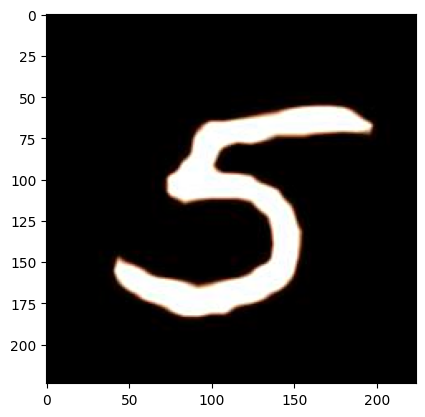

In [20]:
from matplotlib import pyplot as plt

with LuxonisDataset(    
    team_id=team_id,
    dataset_id=dataset_id
) as dataset:
    
    for sample in dataset.fo_dataset:
        # img_path = f"{str(Path.home())}/.cache/luxonis_ml/data/{sample.filepath}"
        print(sample)
        id_sub = dataset.path.split('/')[-1]
        img_rel_path = sample.filepath.split(id_sub)[-1]
        img_path = dataset.path + img_rel_path

        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()
        break
    

In [21]:

# Initialize the ONNX Runtime session for the model
provider = ['CUDAExecutionProvider'] if torch.cuda.is_available() and 'CUDAExecutionProvider' in onnxruntime.get_available_providers() else None
ort_session = onnxruntime.InferenceSession("resnet50-1.onnx", providers=provider)


In [25]:

# Start the Qdrant Docker container
start_docker_qdrant()

# Initialize the Qdrant client
qdrant_client = connect_to_qdrant()
create_collection(qdrant_client, collection_name="mnist3", vector_size=2048, distance=Distance.COSINE)


2023-08-24 14:17:44,095 [INFO] HTTP Request: GET http://localhost:6333/collections/mnist3 "HTTP/1.1 404 Not Found"
2023-08-24 14:17:44,098 [INFO] HTTP Request: DELETE http://localhost:6333/collections/mnist3 "HTTP/1.1 200 OK"
2023-08-24 14:17:44,191 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3 "HTTP/1.1 200 OK"


Container is already running.


In [26]:

# Load the LuxonisDataset
with LuxonisDataset(team_id=team_id, dataset_id=dataset_id) as dataset:
    # Call the _generate_embeddings method
    emb_dict = generate_embeddings(dataset, ort_session, qdrant_client, 
                        qdrant_collection_name="mnist3", 
                        output_layer_name="/Flatten_output_0")


2023-08-24 14:17:47,273 [INFO] HTTP Request: POST http://localhost:6333/collections/mnist3/points "HTTP/1.1 200 OK"
2023-08-24 14:18:12,961 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,005 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,045 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,091 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,135 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 1 / 168 of size 64 to Qdrant.
Upserted batch 2 / 168 of size 64 to Qdrant.
Upserted batch 3 / 168 of size 64 to Qdrant.
Upserted batch 4 / 168 of size 64 to Qdrant.
Upserted batch 5 / 168 of size 64 to Qdrant.


2023-08-24 14:18:13,178 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,224 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,300 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,341 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,385 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 6 / 168 of size 64 to Qdrant.
Upserted batch 7 / 168 of size 64 to Qdrant.
Upserted batch 8 / 168 of size 64 to Qdrant.
Upserted batch 9 / 168 of size 64 to Qdrant.
Upserted batch 10 / 168 of size 64 to Qdrant.


2023-08-24 14:18:13,427 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,470 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,512 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,555 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,598 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 11 / 168 of size 64 to Qdrant.
Upserted batch 12 / 168 of size 64 to Qdrant.
Upserted batch 13 / 168 of size 64 to Qdrant.
Upserted batch 14 / 168 of size 64 to Qdrant.
Upserted batch 15 / 168 of size 64 to Qdrant.


2023-08-24 14:18:13,636 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,673 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,715 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,755 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,798 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,842 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 16 / 168 of size 64 to Qdrant.
Upserted batch 17 / 168 of size 64 to Qdrant.
Upserted batch 18 / 168 of size 64 to Qdrant.
Upserted batch 19 / 168 of size 64 to Qdrant.
Upserted batch 20 / 168 of size 64 to Qdrant.
Upserted batch 21 / 168 of size 64 to Qdrant.


2023-08-24 14:18:13,883 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,923 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,962 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:13,999 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,042 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,083 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 22 / 168 of size 64 to Qdrant.
Upserted batch 23 / 168 of size 64 to Qdrant.
Upserted batch 24 / 168 of size 64 to Qdrant.
Upserted batch 25 / 168 of size 64 to Qdrant.
Upserted batch 26 / 168 of size 64 to Qdrant.
Upserted batch 27 / 168 of size 64 to Qdrant.


2023-08-24 14:18:14,138 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,193 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,238 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,282 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,327 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 28 / 168 of size 64 to Qdrant.
Upserted batch 29 / 168 of size 64 to Qdrant.
Upserted batch 30 / 168 of size 64 to Qdrant.
Upserted batch 31 / 168 of size 64 to Qdrant.
Upserted batch 32 / 168 of size 64 to Qdrant.


2023-08-24 14:18:14,374 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,411 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,451 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,491 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,528 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,574 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 33 / 168 of size 64 to Qdrant.
Upserted batch 34 / 168 of size 64 to Qdrant.
Upserted batch 35 / 168 of size 64 to Qdrant.
Upserted batch 36 / 168 of size 64 to Qdrant.
Upserted batch 37 / 168 of size 64 to Qdrant.
Upserted batch 38 / 168 of size 64 to Qdrant.


2023-08-24 14:18:14,613 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,652 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,692 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,738 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,780 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,822 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 39 / 168 of size 64 to Qdrant.
Upserted batch 40 / 168 of size 64 to Qdrant.
Upserted batch 41 / 168 of size 64 to Qdrant.
Upserted batch 42 / 168 of size 64 to Qdrant.
Upserted batch 43 / 168 of size 64 to Qdrant.
Upserted batch 44 / 168 of size 64 to Qdrant.


2023-08-24 14:18:14,868 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,911 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,953 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:14,996 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,037 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 45 / 168 of size 64 to Qdrant.
Upserted batch 46 / 168 of size 64 to Qdrant.
Upserted batch 47 / 168 of size 64 to Qdrant.
Upserted batch 48 / 168 of size 64 to Qdrant.
Upserted batch 49 / 168 of size 64 to Qdrant.


2023-08-24 14:18:15,080 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,120 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,158 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,196 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,276 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 50 / 168 of size 64 to Qdrant.
Upserted batch 51 / 168 of size 64 to Qdrant.
Upserted batch 52 / 168 of size 64 to Qdrant.
Upserted batch 53 / 168 of size 64 to Qdrant.
Upserted batch 54 / 168 of size 64 to Qdrant.


2023-08-24 14:18:15,315 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,353 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,395 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,439 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,477 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,517 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 55 / 168 of size 64 to Qdrant.
Upserted batch 56 / 168 of size 64 to Qdrant.
Upserted batch 57 / 168 of size 64 to Qdrant.
Upserted batch 58 / 168 of size 64 to Qdrant.
Upserted batch 59 / 168 of size 64 to Qdrant.
Upserted batch 60 / 168 of size 64 to Qdrant.


2023-08-24 14:18:15,558 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,598 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,634 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,676 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,716 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,756 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 61 / 168 of size 64 to Qdrant.
Upserted batch 62 / 168 of size 64 to Qdrant.
Upserted batch 63 / 168 of size 64 to Qdrant.
Upserted batch 64 / 168 of size 64 to Qdrant.
Upserted batch 65 / 168 of size 64 to Qdrant.
Upserted batch 66 / 168 of size 64 to Qdrant.


2023-08-24 14:18:15,804 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,842 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,881 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,924 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:15,965 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,004 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 67 / 168 of size 64 to Qdrant.
Upserted batch 68 / 168 of size 64 to Qdrant.
Upserted batch 69 / 168 of size 64 to Qdrant.
Upserted batch 70 / 168 of size 64 to Qdrant.
Upserted batch 71 / 168 of size 64 to Qdrant.
Upserted batch 72 / 168 of size 64 to Qdrant.


2023-08-24 14:18:16,052 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,095 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,136 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,174 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,210 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,250 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 73 / 168 of size 64 to Qdrant.
Upserted batch 74 / 168 of size 64 to Qdrant.
Upserted batch 75 / 168 of size 64 to Qdrant.
Upserted batch 76 / 168 of size 64 to Qdrant.
Upserted batch 77 / 168 of size 64 to Qdrant.
Upserted batch 78 / 168 of size 64 to Qdrant.


2023-08-24 14:18:16,298 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,338 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,377 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,417 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,469 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,509 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 79 / 168 of size 64 to Qdrant.
Upserted batch 80 / 168 of size 64 to Qdrant.
Upserted batch 81 / 168 of size 64 to Qdrant.
Upserted batch 82 / 168 of size 64 to Qdrant.
Upserted batch 83 / 168 of size 64 to Qdrant.
Upserted batch 84 / 168 of size 64 to Qdrant.


2023-08-24 14:18:16,564 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,604 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,643 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,679 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,717 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,754 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 85 / 168 of size 64 to Qdrant.
Upserted batch 86 / 168 of size 64 to Qdrant.
Upserted batch 87 / 168 of size 64 to Qdrant.
Upserted batch 88 / 168 of size 64 to Qdrant.
Upserted batch 89 / 168 of size 64 to Qdrant.
Upserted batch 90 / 168 of size 64 to Qdrant.


2023-08-24 14:18:16,792 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,831 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,869 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,909 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:16,968 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,008 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 91 / 168 of size 64 to Qdrant.
Upserted batch 92 / 168 of size 64 to Qdrant.
Upserted batch 93 / 168 of size 64 to Qdrant.
Upserted batch 94 / 168 of size 64 to Qdrant.
Upserted batch 95 / 168 of size 64 to Qdrant.
Upserted batch 96 / 168 of size 64 to Qdrant.


2023-08-24 14:18:17,050 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,094 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,130 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,170 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,208 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,249 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 97 / 168 of size 64 to Qdrant.
Upserted batch 98 / 168 of size 64 to Qdrant.
Upserted batch 99 / 168 of size 64 to Qdrant.
Upserted batch 100 / 168 of size 64 to Qdrant.
Upserted batch 101 / 168 of size 64 to Qdrant.
Upserted batch 102 / 168 of size 64 to Qdrant.


2023-08-24 14:18:17,288 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,328 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,369 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,407 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,445 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,490 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 103 / 168 of size 64 to Qdrant.
Upserted batch 104 / 168 of size 64 to Qdrant.
Upserted batch 105 / 168 of size 64 to Qdrant.
Upserted batch 106 / 168 of size 64 to Qdrant.
Upserted batch 107 / 168 of size 64 to Qdrant.
Upserted batch 108 / 168 of size 64 to Qdrant.


2023-08-24 14:18:17,528 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,569 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,609 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,649 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,688 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,728 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 109 / 168 of size 64 to Qdrant.
Upserted batch 110 / 168 of size 64 to Qdrant.
Upserted batch 111 / 168 of size 64 to Qdrant.
Upserted batch 112 / 168 of size 64 to Qdrant.
Upserted batch 113 / 168 of size 64 to Qdrant.
Upserted batch 114 / 168 of size 64 to Qdrant.


2023-08-24 14:18:17,769 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,808 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,847 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,889 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,928 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:17,969 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 115 / 168 of size 64 to Qdrant.
Upserted batch 116 / 168 of size 64 to Qdrant.
Upserted batch 117 / 168 of size 64 to Qdrant.
Upserted batch 118 / 168 of size 64 to Qdrant.
Upserted batch 119 / 168 of size 64 to Qdrant.
Upserted batch 120 / 168 of size 64 to Qdrant.


2023-08-24 14:18:18,008 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,047 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,089 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,126 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,166 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,210 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 121 / 168 of size 64 to Qdrant.
Upserted batch 122 / 168 of size 64 to Qdrant.
Upserted batch 123 / 168 of size 64 to Qdrant.
Upserted batch 124 / 168 of size 64 to Qdrant.
Upserted batch 125 / 168 of size 64 to Qdrant.
Upserted batch 126 / 168 of size 64 to Qdrant.


2023-08-24 14:18:18,250 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,289 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,328 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,372 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,418 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,462 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 127 / 168 of size 64 to Qdrant.
Upserted batch 128 / 168 of size 64 to Qdrant.
Upserted batch 129 / 168 of size 64 to Qdrant.
Upserted batch 130 / 168 of size 64 to Qdrant.
Upserted batch 131 / 168 of size 64 to Qdrant.
Upserted batch 132 / 168 of size 64 to Qdrant.


2023-08-24 14:18:18,502 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,546 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,587 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,628 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,668 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 133 / 168 of size 64 to Qdrant.
Upserted batch 134 / 168 of size 64 to Qdrant.
Upserted batch 135 / 168 of size 64 to Qdrant.
Upserted batch 136 / 168 of size 64 to Qdrant.
Upserted batch 137 / 168 of size 64 to Qdrant.


2023-08-24 14:18:18,711 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,752 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,793 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,838 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,879 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:18,920 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 138 / 168 of size 64 to Qdrant.
Upserted batch 139 / 168 of size 64 to Qdrant.
Upserted batch 140 / 168 of size 64 to Qdrant.
Upserted batch 141 / 168 of size 64 to Qdrant.
Upserted batch 142 / 168 of size 64 to Qdrant.
Upserted batch 143 / 168 of size 64 to Qdrant.


2023-08-24 14:18:18,961 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,000 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,042 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,085 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,126 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,169 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 144 / 168 of size 64 to Qdrant.
Upserted batch 145 / 168 of size 64 to Qdrant.
Upserted batch 146 / 168 of size 64 to Qdrant.
Upserted batch 147 / 168 of size 64 to Qdrant.
Upserted batch 148 / 168 of size 64 to Qdrant.
Upserted batch 149 / 168 of size 64 to Qdrant.


2023-08-24 14:18:19,214 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,255 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,295 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,342 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,383 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,422 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 150 / 168 of size 64 to Qdrant.
Upserted batch 151 / 168 of size 64 to Qdrant.
Upserted batch 152 / 168 of size 64 to Qdrant.
Upserted batch 153 / 168 of size 64 to Qdrant.
Upserted batch 154 / 168 of size 64 to Qdrant.
Upserted batch 155 / 168 of size 64 to Qdrant.


2023-08-24 14:18:19,464 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,504 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,547 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,586 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,623 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,659 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 156 / 168 of size 64 to Qdrant.
Upserted batch 157 / 168 of size 64 to Qdrant.
Upserted batch 158 / 168 of size 64 to Qdrant.
Upserted batch 159 / 168 of size 64 to Qdrant.
Upserted batch 160 / 168 of size 64 to Qdrant.
Upserted batch 161 / 168 of size 64 to Qdrant.


2023-08-24 14:18:19,699 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,737 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,774 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,816 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,857 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"
2023-08-24 14:18:19,895 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 162 / 168 of size 64 to Qdrant.
Upserted batch 163 / 168 of size 64 to Qdrant.
Upserted batch 164 / 168 of size 64 to Qdrant.
Upserted batch 165 / 168 of size 64 to Qdrant.
Upserted batch 166 / 168 of size 64 to Qdrant.
Upserted batch 167 / 168 of size 64 to Qdrant.


2023-08-24 14:18:19,931 [INFO] HTTP Request: PUT http://localhost:6333/collections/mnist3/points?wait=true "HTTP/1.1 200 OK"


Upserted batch 168 / 168 of size 56 to Qdrant.
Embeddings generation and insertion completed!


In [27]:
first_emb = None

with LuxonisDataset(    
    team_id=team_id,
    dataset_id=dataset_id
) as dataset:
    # get a specific sample from dataset
    first_sample = list(emb_dict.keys())[0]
    first_emb = emb_dict[first_sample]
    sample_id = first_sample
    
    # sample_id = '64e758bdca1096d3483d18f4'
    sample = dataset.fo_dataset[sample_id]
    print(sample)

<Sample: {
    'id': '64e758bbca1096d3483d0327',
    'media_type': 'image',
    'filepath': '/luxonis_id/datasets/64e7566cca1096d3483cb822/image/b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f.jpg',
    'tags': [],
    'metadata': None,
    'mnist': <Group: {'id': '64e756a6ca1096d3483cb826', 'name': 'image'}>,
    'version': 1.0,
    'latest': False,
    'split': 'train',
    'class': <Classifications: {
        'classifications': [
            <Classification: {
                'id': '64e758b7ca1096d3483cea27',
                'tags': [],
                'label': '5',
                'confidence': None,
                'logits': None,
            }>,
        ],
        'logits': None,
    }>,
    'instance_id': 'b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f',
    'tid': '64e756a6ca1096d3483cb827',
}>


In [29]:
# Search for the nearest neighbors
search_results = search_embeddings(client, np.array(first_emb), collection_name="mnist3", top=5)
print(np.array(search_results))

2023-08-24 14:20:18,031 [INFO] HTTP Request: POST http://localhost:6333/collections/mnist3/points/search "HTTP/1.1 200 OK"


[ScoredPoint(id='b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f', version=163, score=1.0, payload={'class': '5', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id/datasets/64e7566cca1096d3483cb822/image/b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f.jpg', 'instance_id': 'b1e7fbba-46bb-5050-b4f6-f84d41fe4e8f', 'sample_id': '64e765fd7d05bba6e602ed8e', 'split': 'val'}, vector=None)
 ScoredPoint(id='0594bd6b-31be-5326-b791-fc7be96fb9f6', version=154, score=0.97462344, payload={'class': '5', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id/datasets/64e7566cca1096d3483cb822/image/0594bd6b-31be-5326-b791-fc7be96fb9f6.jpg', 'instance_id': '0594bd6b-31be-5326-b791-fc7be96fb9f6', 'sample_id': '64e765fb7d05bba6e602eb2f', 'split': 'val'}, vector=None)
 ScoredPoint(id='f3f1c59d-1f5f-5e0f-832e-caa0411d2e55', version=52, score=0.97452646, payload={'class': '5', 'image_path': '/home/paperspace/.cache/luxonis_ml/data/luxonis_id/datasets/64e7566cca1096d3483cb822/image/f3f1c59d-1f5f-5e0f-832

## Embeddings Processing

In [30]:
from luxonis_ml.embeddings.embeddings_processing import *